In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I'm exploring incoming call data to a sales team from 2019

The data is spread over 3 separate CSV files ranging from July to the end of the year.

The analysis covers retrieving data from a database, data manipulation, computation and visualization, as well as answering business questions.

I use Python with NumPy and pandas for data manipulation and seaborn for visualization.

In [34]:
data1 = pd.read_csv('OctDec.csv', parse_dates=[['Call Date', 'Call Time']])
data1.columns = ['Call Time', 'From Name', 'From #', 'Dialed #', 'Answered by', 'Duration(seconds)', 'Null']
#Careful to include daylight savings before Nov 3rd as it's not included in the data
daylight_ind = data1[data1['Call Time'] < pd.to_datetime('2019-11-03')].index[0]
data1.iloc[daylight_ind:,0] = data1.iloc[daylight_ind:,0] + pd.DateOffset(hours = 1)

In [35]:
data2 = pd.read_csv('JulOct.csv', parse_dates=[['Call Date', 'Call Time']])
data2.columns = ['Call Time', 'From Name', 'From #', 'Dialed #', 'Answered by', 'Duration(seconds)', 'Null']
data2['Call Time'] = data2['Call Time'] + pd.DateOffset(hours = 1)

In [36]:
data3 = pd.read_csv('Jul.csv', parse_dates=[['Call Date', 'Call Time']])
data3.columns = ['Call Time', 'From Name', 'From #', 'Dialed #', 'Answered by', 'Duration(seconds)', 'Null']
data3['Call Time'] = data3['Call Time'] + pd.DateOffset(hours = 1)

In [37]:
#Take the 3 spreadsheets and combine into 1
data_combine = pd.concat([data1, data2, data3]).sort_values('Call Time',ignore_index=True)
#Dropping duplicate entries if they are the same time, caller, and person who answers
data_combine.drop_duplicates(['Call Time', 'From #', 'Answered by'], keep = 'first', inplace = True)
data_combine.sort_values(['Call Time', 'From #'], inplace = True)
data_combine.drop(columns = 'Null', axis = 1, inplace = True)

I'm going to start by creating a new column to filter for the business hours, Monday - Friday, 8 AM - 5 PM

From there, I add some new columns that will allow for time based insights, including the day, hour, and week of call

In [38]:
#Create a column to sort time with
data_seg = data_combine
data_seg['ts'] = pd.to_datetime((data_seg['Call Time']))
data_seg = pd.DataFrame(data_combine, columns=['ts'])
data_seg.ts = pd.to_datetime(data_seg.ts)

#Implement time restraints for business hours
time_sort = data_combine[data_combine.ts.dt.strftime('%H:%M:%S').between('08:00:00','17:00:00')]

#Business days to check for
day_check = [0, 1, 2, 3, 4]

#Drop weekend days from the dataset
day_wk = time_sort['Call Time'].dt.dayofweek
df_main = time_sort.drop(day_wk[~(day_wk.isin(day_check))].index).reset_index(drop=True)

#create hourly breakdowns for peak time during business day
df_main['Time of Call'] = df_main.ts.dt.strftime('%H').copy().astype(int)

#create a day of week column for daily stats
df_main['Day of Week'] = df_main['Call Time'].dt.day_name()

#create a day of year column to compute weeks
df_main['Day of Year'] = df_main['Call Time'].dt.dayofyear

#create a week of year column for weekly stats
df_main['Week of Year'] = round((df_main['Day of Year']+1)/7, 0).astype(int)

#create a voicemail column to count how many calls are being missed and when
df_main['VM Check'] = df_main['Answered by'].str.contains("VMail", na=False)

Let's take a look at the weekly call volume from July through December.

Although this doesn't cover the whole year, we can get a sense of seasonality.

0    35
1    41
2    45
3    48
4    51
dtype: int64


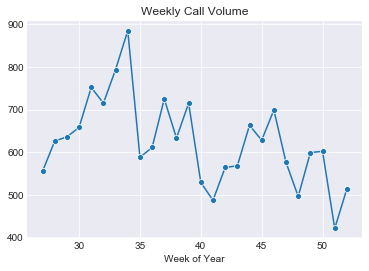

In [39]:
#Create Series for weekly volume graph
week_ind = df_main[df_main['Week of Year'] >= 27].index
wk_g = df_main.loc[week_ind,'Week of Year'].value_counts(sort=False)

#Find the weeks where holidays occur
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2019-07-05', end='2019-12-31')
holidays = pd.to_datetime(holidays).dayofyear
holidays = pd.Series(holidays)
hol_wk = round((holidays+1)/7, 0).astype(int)

#Create graph and sort by index
plt.style.use('seaborn-darkgrid')
wk_grph = sns.lineplot(x=wk_g.index, y=wk_g, marker='o')
wk_grph.set_title('Weekly Call Volume')
wk_grph.set_ylabel('')
wk_grph.set_xlabel('Week of Year')

print(hol_wk)

We can see that there's a strong peak early, with smaller peaks through the rest of the year.

The large drop offs actually coincide with the weeks that contain holidays (35, 41, 45, 48, 51). This could point to seasonality built around promotions that would cause the phone traffic to heavily decrease following the holiday.

Again, this data only covers a partial year, so we can't read too far into what could just be variance.

Let's look at the call volume throughout the week.

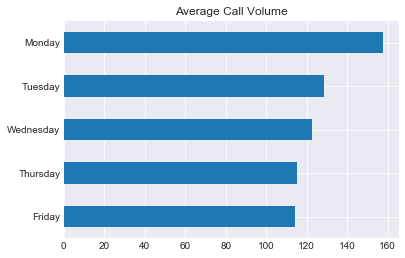

In [40]:
#Create Series for daily average graph

#Get total weeks for the data and find average for each day
wk_min = df_main['Week of Year'].min()
wk_max = df_main['Week of Year'].max()
tot_wks = wk_max - wk_min
day_g = (df_main['Day of Week'].value_counts(sort=False))/(tot_wks)
day_g = day_g.reindex(['Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday'])

#Create graph and sort by index
plt.style.use('seaborn-darkgrid')
day_grph = day_g[day_g.index].plot.barh()
day_grph.set_title('Average Call Volume')

plt.show()

Calls come in heavy at the start of the week and taper off through the rest of the week. 

We can add the hour of the call for more insight into peak times.

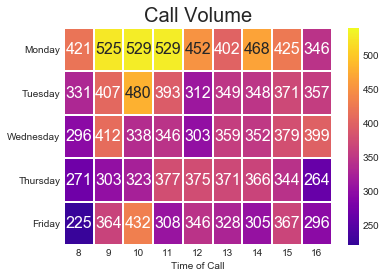

In [41]:
#Create a new DF that counts the number of calls per hour based on the day of the call then plot it over a heatmap
df_2 = df_main.groupby(['Day of Week'],sort=False)['Time of Call'].value_counts()
max_calls = df_2.max()
min_calls = df_2.min()
df_2 = df_2.unstack()

df_2_heat = sns.heatmap(df_2, 
    cmap = 'plasma',
    center = df_2.unstack().mean(),             # Using mean for scale
    vmin = 20*np.floor_divide(min_calls,20),    # Rounded to 20 under minimum
    vmax = 20+20*np.floor_divide(max_calls,20), # Rounded to 20 over max value
    annot = True,                               # label cells for value clarity
    fmt = ".0f",
    linewidth = 1,
    linecolor = 'white',
    annot_kws = {
       'fontsize': 16,
       'fontweight': 'normal',
       'fontfamily': 'sans-serif'
    }                  
)
df_2_heat.set_ylabel('')

plt.yticks(rotation=0)               # rotate labels of y axis

plt.title("Call Volume",            # set a title 
          y = 1.05,                   # set position of title
          size = 20);                 # set fontsize of title

Not only is the beginning of the week a hot period, from 9-11 also seems to be the busiest hours.

Although Friday is the quitest day, 10 AM sees a surge of traffic with volume that hasn't been hit since Tuesday at that time.

Let's see if the traffic is being handled appropriately or if there are more missed calls when traffic picks up.

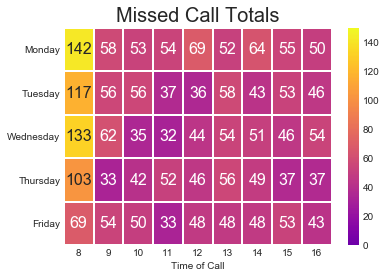

In [42]:
#Create the same DF as the last one, except this will only include missed calls
df_vm = df_main[df_main['VM Check'] == True]
df_vm = df_vm.groupby(['Day of Week'],sort=False)['Time of Call'].value_counts()

max_calls = df_vm.max()
min_calls = df_vm.min()
df_vm = df_vm.unstack()

df_vm_heat = sns.heatmap(df_vm, 
    cmap = 'plasma',
    center = df_vm.unstack().mean(),             # Using mean for scale
    vmin = 0,
    vmax = 10+10*np.floor_divide(max_calls,10),           # Rounded to 10 over max value
    annot = True,                               # label cells for value clarity
    fmt = ".0f",
    linewidth = 1,
    linecolor = 'white',
    annot_kws = {
       'fontsize': 16,
       'fontweight': 'normal',
       'fontfamily': 'sans-serif'
    }
)

df_vm_heat.set_ylabel('')
plt.yticks(rotation=0)               # rotate labels of y axis

plt.title("Missed Call Totals",     # set a title 
          y = 1.05,                   # set position of title
          size = 20);                 # set fontsize of title

Missed calls do go up slightly with the higher call volumes, but there are much more missed calls at 8 AM than call volume alone can explain.

It looks like an oversight in how the system is set up for the early hours and who is covering the phones. This can surely be an area of improvement.

In conclusion, we can see that sales calls have a seasonality aspect to them which looks to be tied to the holidays.

We can also see that early in the week and on average, early in the day sees the highest phone traffic.

There's a hole in the system that's allowing far too many missed calls between 8-9 AM that can be targeted as an area for improvement moving forward.